**Smart Healthcare Expense & Disease Prediction System**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [10, 6]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report
from sklearn.cluster import KMeans

In [ ]:
# Step 2: Load Dataset
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
data = pd.read_csv(url)

print("Dataset Loaded:")
display(data.head())

Dataset Loaded:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
# Step 3: Initial Data Overview
print("\nData Info:")
data.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
print("\nStatistical Summary:")
display(data.describe())


Statistical Summary:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
print("\nCheck for missing values:")
print(data.isnull().sum())


Check for missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [ ]:
print("\nDuplicate rows count:", data.duplicated().sum())


Duplicate rows count: 1


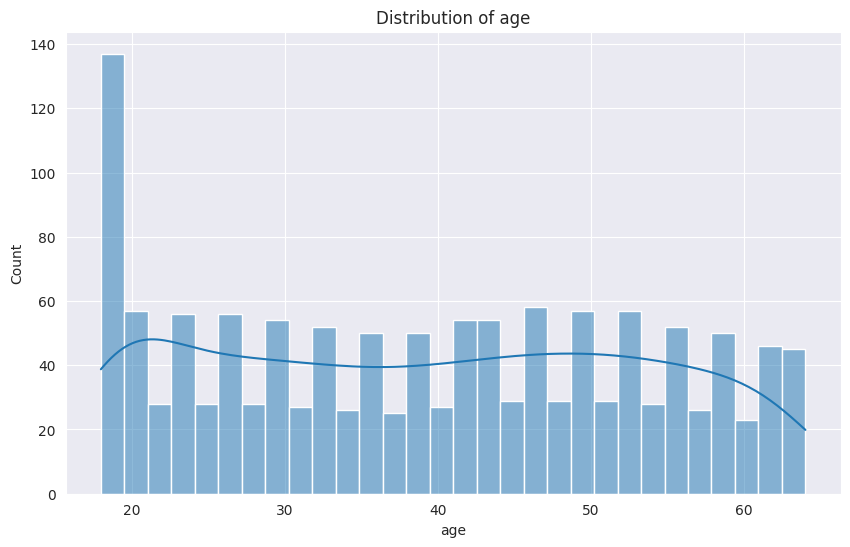

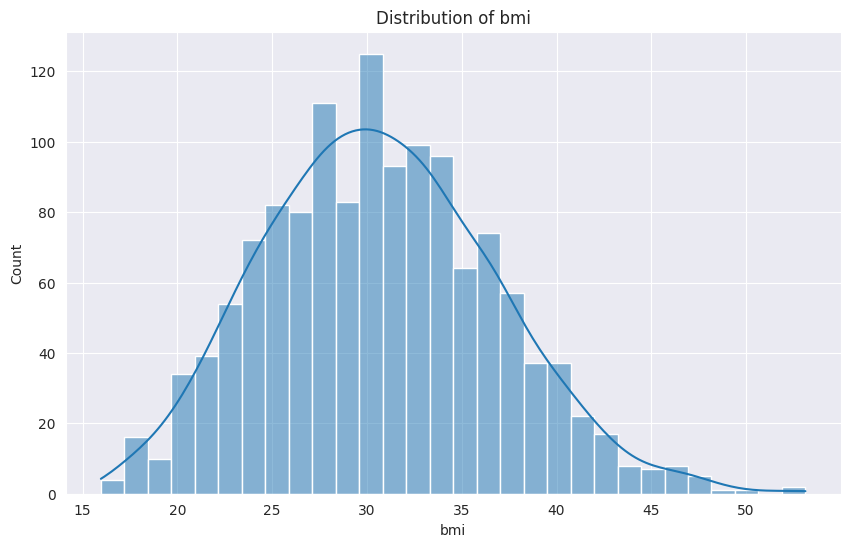

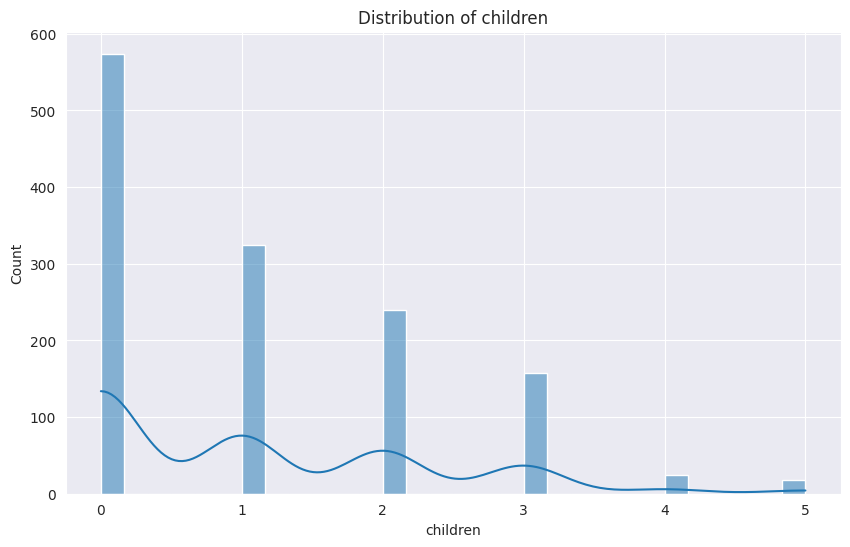

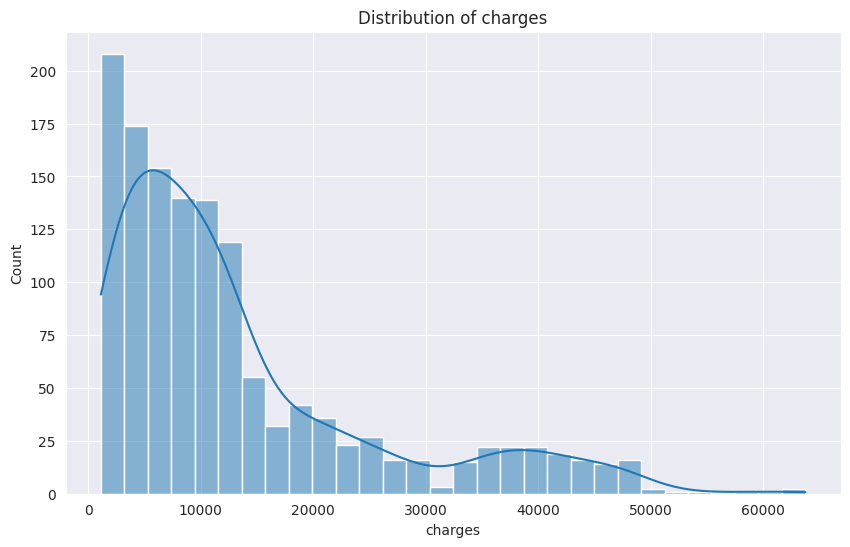

In [ ]:
# Step 4: Exploratory Data Analysis (EDA)

# Distribution of Numerical Features
numerical_features = ['age', 'bmi', 'children', 'charges']
for col in numerical_features:
    plt.figure()
    sns.histplot(data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

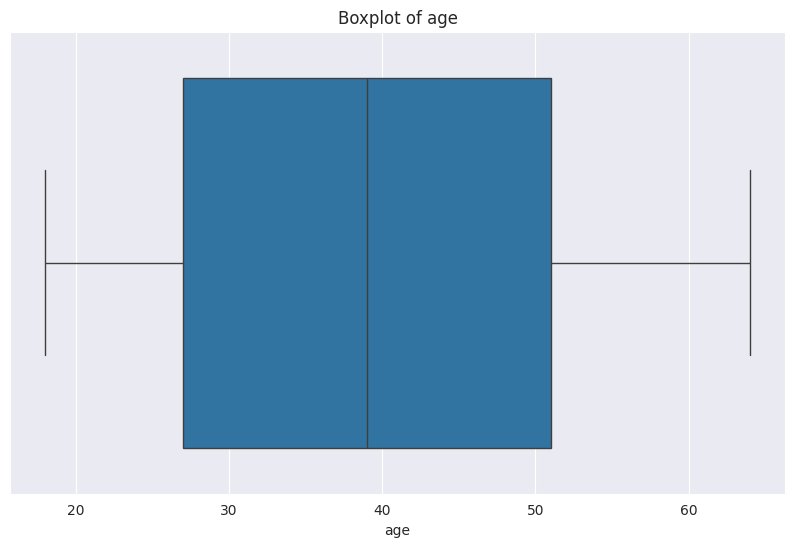

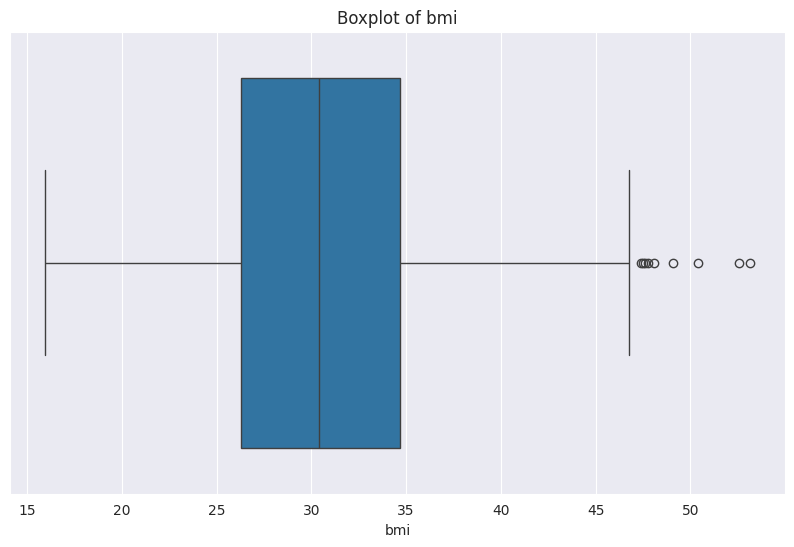

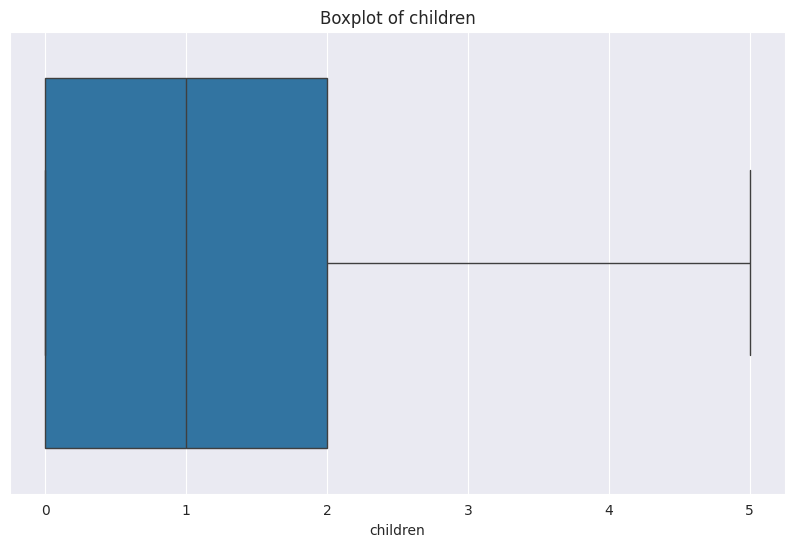

In [ ]:
# Boxplots to check for outliers
for col in numerical_features[:-1]:
    plt.figure()
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

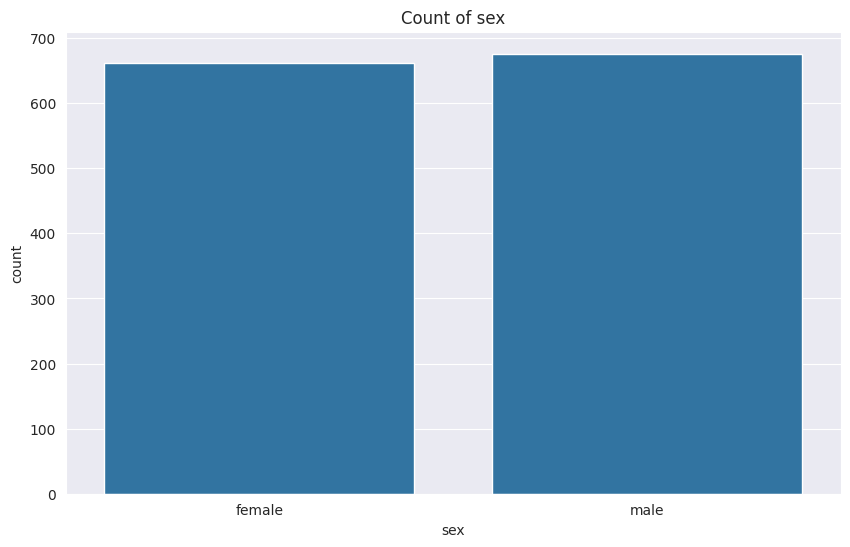

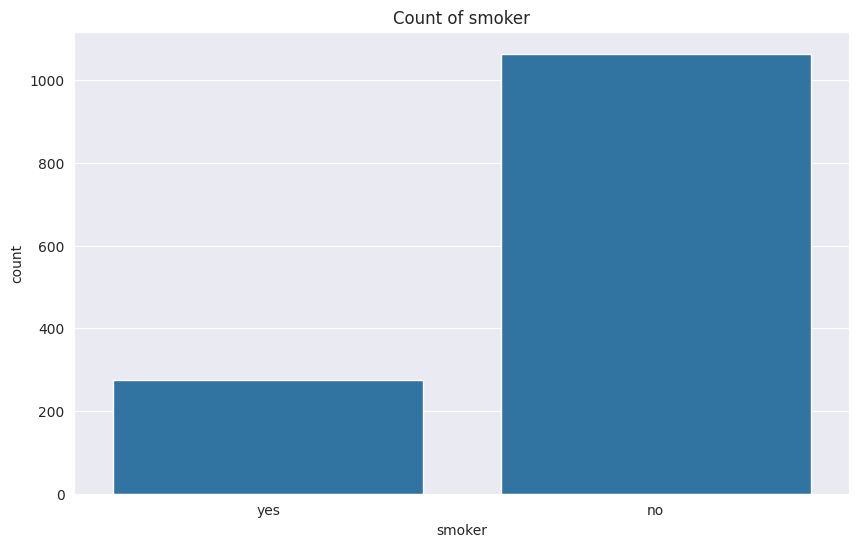

In [ ]:
# Distribution of categorical variables
categorical_features = ['sex', 'smoker']
for col in categorical_features:
    plt.figure()
    sns.countplot(x=data[col])
    plt.title(f'Count of {col}')
    plt.show()

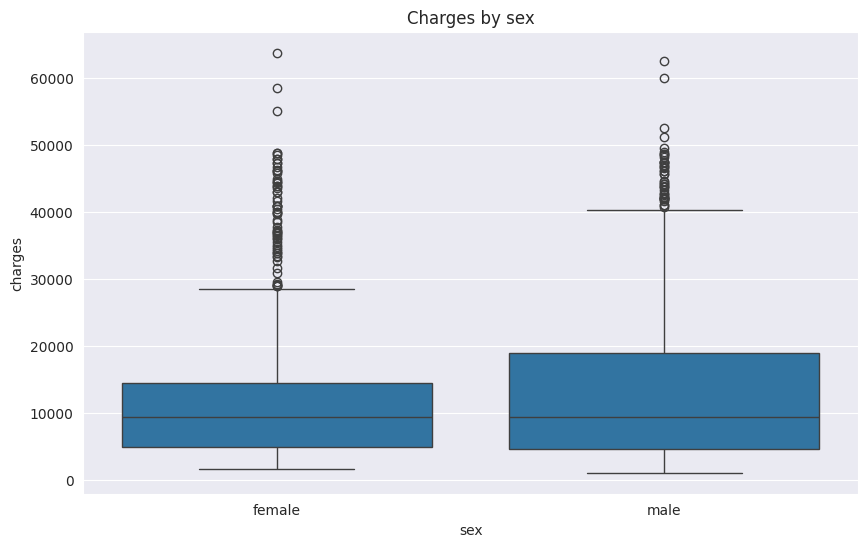

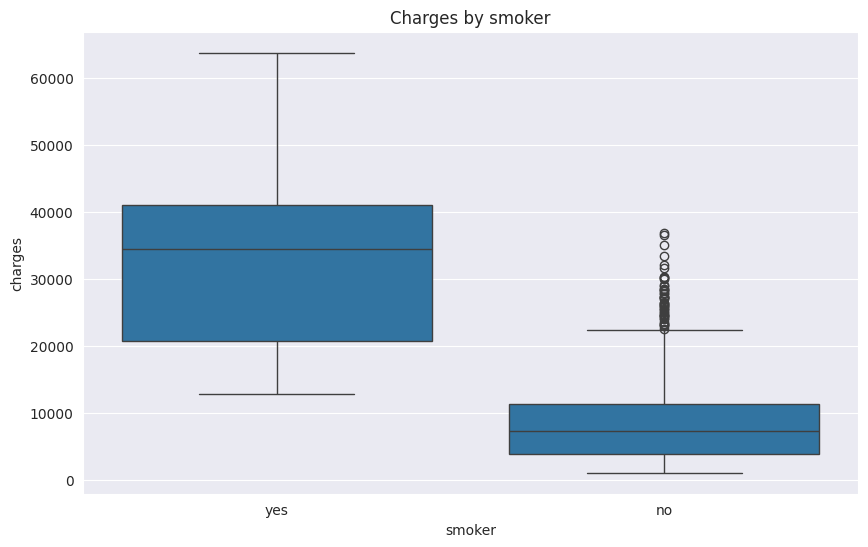

In [ ]:
# Boxplot Charges by Categorical features
for col in categorical_features:
    plt.figure()
    sns.boxplot(x=data[col], y=data['charges'])
    plt.title(f'Charges by {col}')
    plt.show()

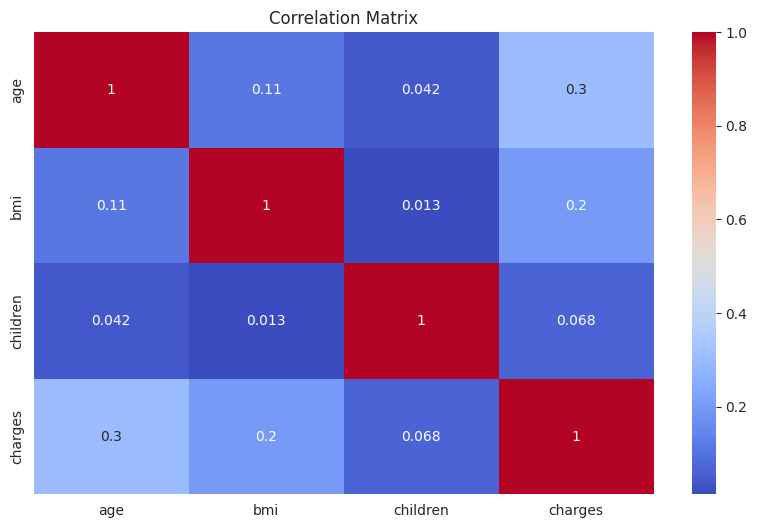

In [ ]:
# Correlation Heatmap
# Select only numerical columns for correlation calculation
numerical_data = data.select_dtypes(include=[np.number])
corr = numerical_data.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

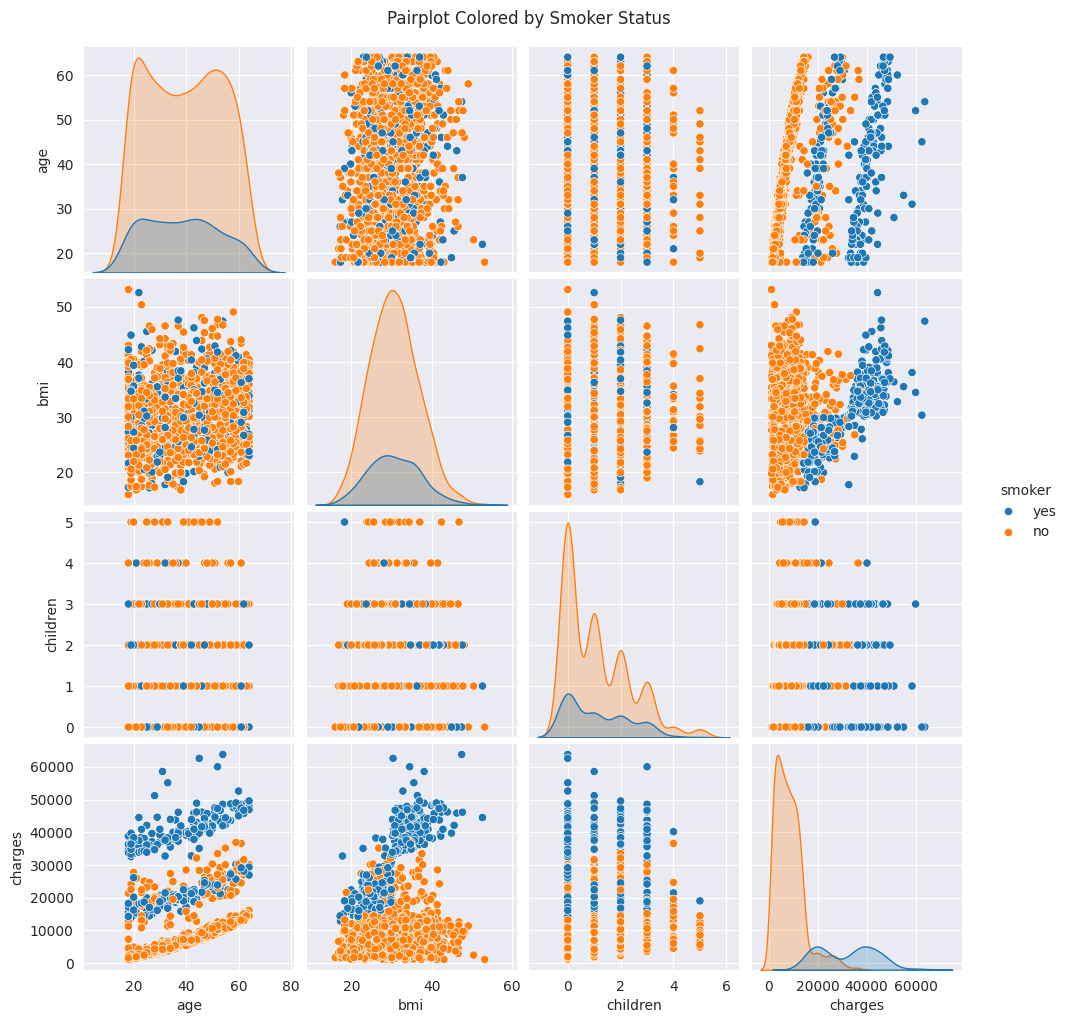

In [ ]:
# Pairplot - relations and clusters by smoker status
sns.pairplot(data, hue='smoker')
plt.suptitle("Pairplot Colored by Smoker Status", y=1.02)
plt.show()

/tmp/ipython-input-4026889756.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bmi_category', data=data, palette='Set2')


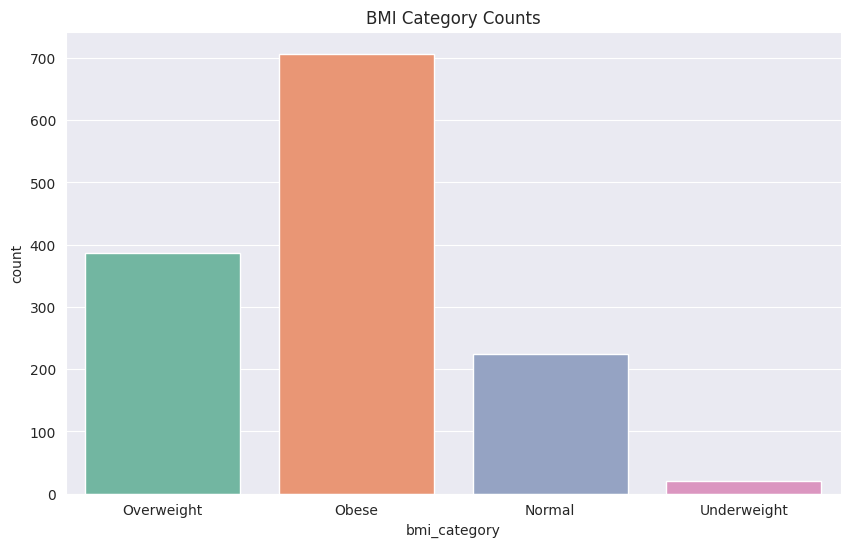

In [ ]:
# Step 5: Feature Engineering & Preprocessing

# Create BMI categories (underweight, normal, overweight, obese)
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

data['bmi_category'] = data['bmi'].apply(bmi_category)

plt.figure()
sns.countplot(x='bmi_category', data=data, palette='Set2')
plt.title("BMI Category Counts")
plt.show()

In [ ]:
# Outlier Removal for Charges using IQR
Q1 = data['charges'].quantile(0.25)
Q3 = data['charges'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['charges'] < lower_bound) | (data['charges'] > upper_bound)].shape[0]
print(f"Number of outliers in charges: {outliers}")

Number of outliers in charges: 139


In [ ]:
# Remove outliers
data = data[(data['charges'] >= lower_bound) & (data['charges'] <= upper_bound)]
print(f"Data shape after removing outliers: {data.shape}")

Data shape after removing outliers: (1199, 8)


In [ ]:
# Step 6: Encode categorical variables

# Label encode bmi_category for modeling
label_enc = LabelEncoder()
data['bmi_category_enc'] = label_enc.fit_transform(data['bmi_category'])

# Features and target
features = ['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'bmi_category_enc']
X = data[features]
y = data['charges']

In [ ]:
numerical_cols = ['age', 'bmi', 'children', 'bmi_category_enc']
categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

In [ ]:
# Step 7: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression Performance:
R² Score: 0.5568
MSE: 27647351.6858
RMSE: 5258.0749
MAE: 2797.0320


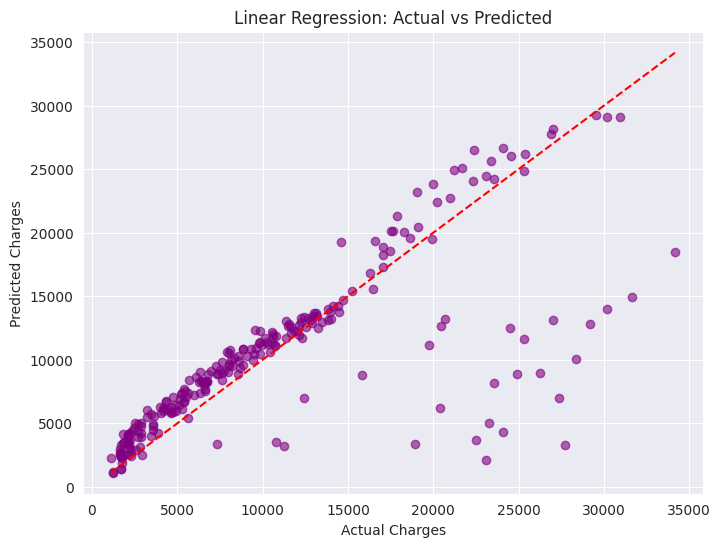

In [ ]:
# Step 8: Regression Model Training and Evaluation Function
def evaluate_regression_model(name, model):
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Performance:")
    print(f"R² Score: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(8,6))
    plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Charges")
    plt.ylabel("Predicted Charges")
    plt.title(f"{name}: Actual vs Predicted")
    plt.show()

# Train and Evaluate Different Regression Models
results = [] # Initialize the results list
evaluate_regression_model("Linear Regression", LinearRegression())

Ridge Regression Performance:
R² Score: 0.5579
MSE: 27575547.8138
RMSE: 5251.2425
MAE: 2791.5766


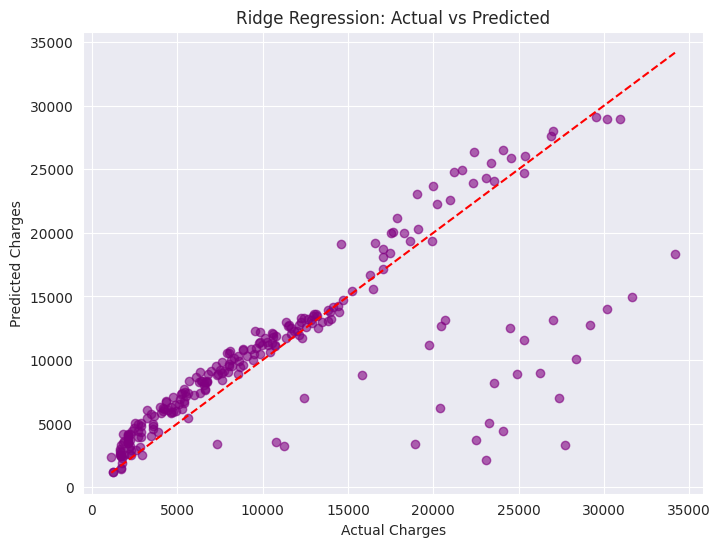

In [ ]:

evaluate_regression_model("Ridge Regression", Ridge(alpha=1.0))

Lasso Regression Performance:
R² Score: 0.5568
MSE: 27647317.0629
RMSE: 5258.0716
MAE: 2797.0247


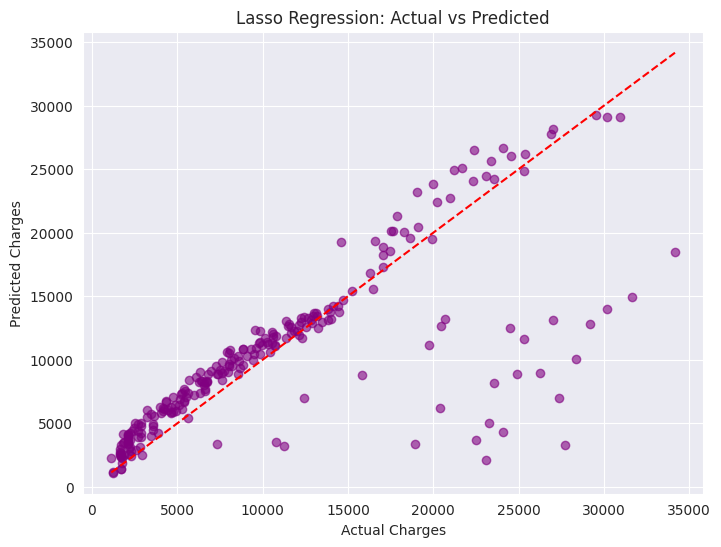

In [ ]:
evaluate_regression_model("Lasso Regression", Lasso(alpha=0.01))


ElasticNet Regression Performance:
R² Score: 0.5611
MSE: 27380338.4948
RMSE: 5232.6225
MAE: 2778.8538


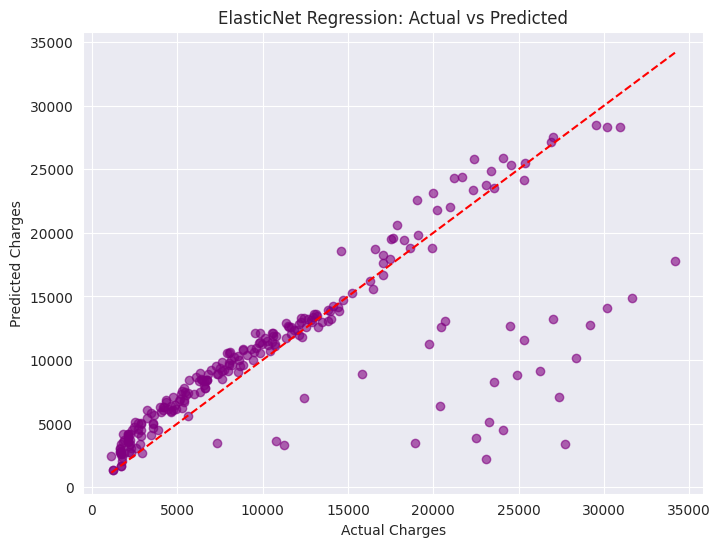

In [ ]:
evaluate_regression_model("ElasticNet Regression", ElasticNet(alpha=0.01, l1_ratio=0.5))


Random Forest Regressor Performance:
R² Score: 0.5607
MSE: 27403463.4422
RMSE: 5234.8317
MAE: 2689.3716


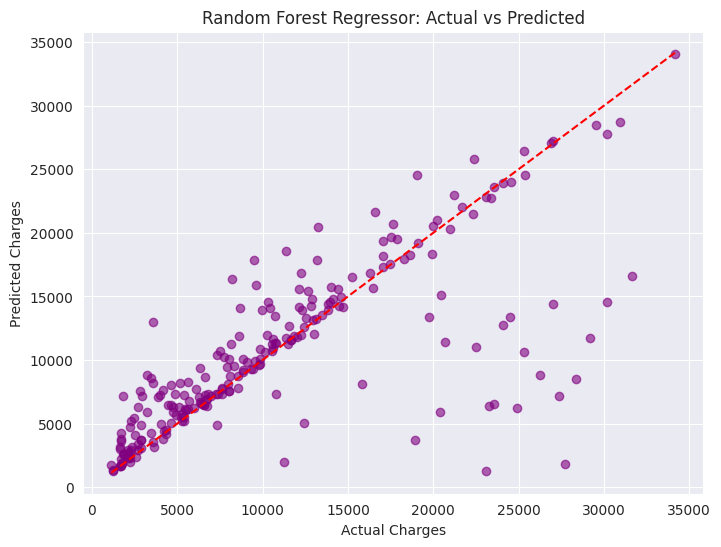

In [ ]:
evaluate_regression_model("Random Forest Regressor", RandomForestRegressor(n_estimators=100, random_state=42))

In [ ]:
results = []

def evaluate_regression_model(name, model):
    from sklearn.pipeline import make_pipeline
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    results.append({
        'Model': name,
        'R2 Score': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae
    })
    print(f"{name}: R2={r2:.4f}")

models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.01)),
    ("ElasticNet Regression", ElasticNet(alpha=0.01, l1_ratio=0.5)),
    ("Random Forest Regressor", RandomForestRegressor(n_estimators=100, random_state=42))
]

for model_name, model_obj in models:
    evaluate_regression_model(model_name, model_obj)

results_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
display(results_df.sort_values(by="R2 Score", ascending=False))


Linear Regression: R2=0.5568
Ridge Regression: R2=0.5579
Lasso Regression: R2=0.5568
ElasticNet Regression: R2=0.5611
Random Forest Regressor: R2=0.5607

Model Comparison Table:


,Model,R2 Score,MSE,RMSE,MAE
3,ElasticNet Regression,0.561074,2.738034e+07,5232.622526,2778.853821
4,Random Forest Regressor,0.560703,2.740346e+07,5234.831749,2689.371620
1,Ridge Regression,0.557945,2.757555e+07,5251.242502,2791.576617
2,Lasso Regression,0.556794,2.764732e+07,5258.071611,2797.024703
0,Linear Regression,0.556794,2.764735e+07,5258.074903,2797.031953


/tmp/ipython-input-4152637309.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='R2 Score', data=results_df, palette='viridis')


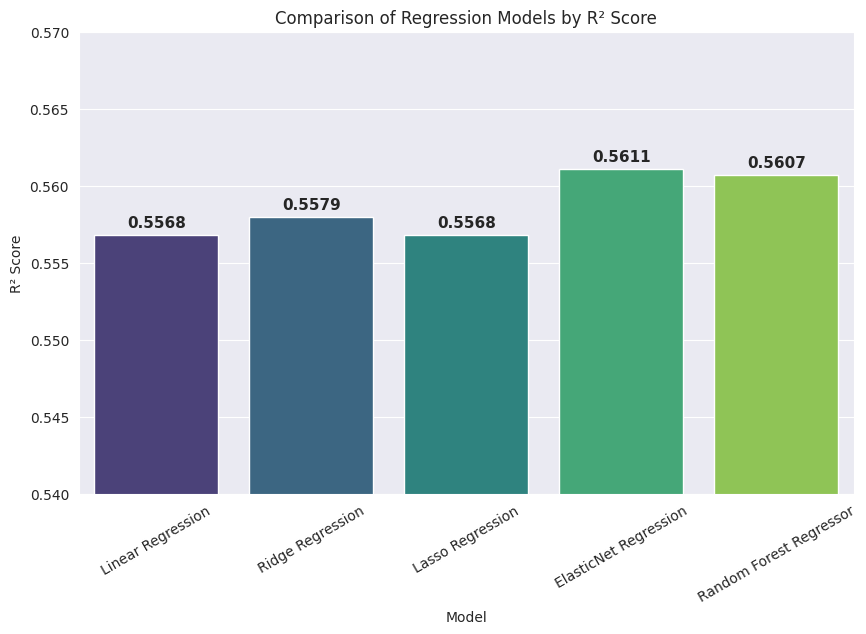

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
ax = sns.barplot(x='Model', y='R2 Score', data=results_df, palette='viridis')
plt.title("Comparison of Regression Models by R² Score")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.ylim(0.54, 0.57)  # Set this to just above and below your R² value range
plt.xticks(rotation=30)

for i, v in enumerate(results_df["R2 Score"]):
    ax.text(i, v + 0.0005, f"{v:.4f}", ha='center', fontweight='bold', fontsize=11)

plt.show()


Class distribution in full data:
risk
Low Risk       712
Medium Risk    464
High Risk       23
Name: count, dtype: int64
Class distribution in test set:
risk_label
1    142
2     93
0      5
Name: count, dtype: int64


/tmp/ipython-input-3969792614.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='bmi_category', data=data, palette='Set2')


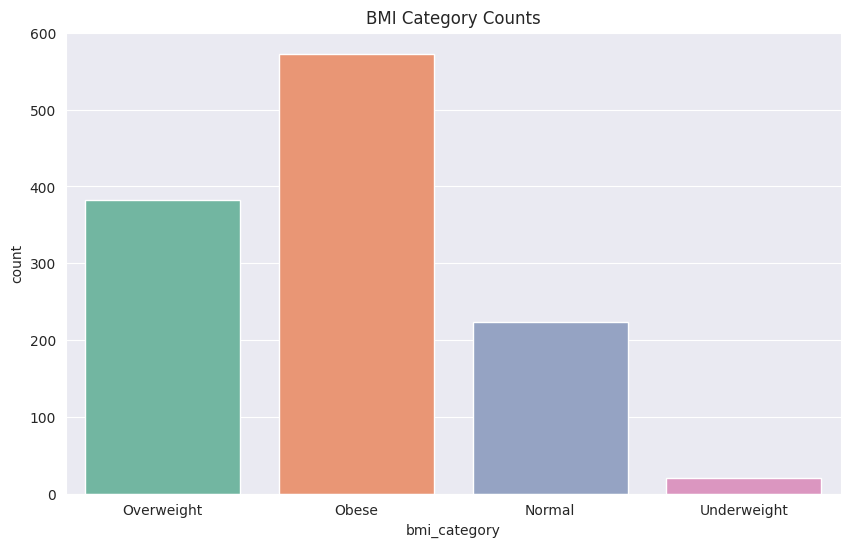

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Create disease risk classes from charges
data['risk'] = pd.cut(data['charges'], bins=[0, 10000, 30000, np.inf],
                      labels=['Low Risk', 'Medium Risk', 'High Risk'])

le_risk = LabelEncoder()
data['risk_label'] = le_risk.fit_transform(data['risk'])

# Check for class imbalance
print("Class distribution in full data:")
print(data['risk'].value_counts())

X = data[features]  # use your model features
y = data['risk_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Class distribution in test set:")
print(pd.Series(y_test).value_counts())

plt.figure()
sns.countplot(x='risk_label', data=data, palette='Set2')
plt.title("risk_label")
plt.show()


Logistic Regression Classification Report:
              precision    recall  f1-score   support

   High Risk       0.09      0.40      0.15         5
    Low Risk       0.87      0.86      0.87       142
 Medium Risk       0.72      0.60      0.65        93

    accuracy                           0.75       240
   macro avg       0.56      0.62      0.56       240
weighted avg       0.80      0.75      0.77       240

Accuracy: 0.7500, Precision: 0.7957


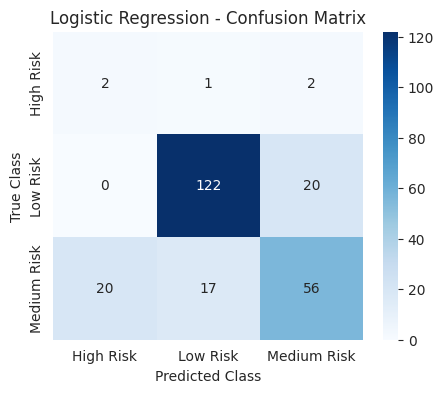

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=500, class_weight='balanced'))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_risk.classes_))
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}")

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=le_risk.classes_,
            yticklabels=le_risk.classes_)
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

Decision Tree Classification Report:
              precision    recall  f1-score   support

   High Risk       0.25      0.20      0.22         5
    Low Risk       0.84      0.86      0.85       142
 Medium Risk       0.75      0.73      0.74        93

    accuracy                           0.80       240
   macro avg       0.61      0.60      0.60       240
weighted avg       0.79      0.80      0.79       240

Accuracy: 0.7958, Precision: 0.7926


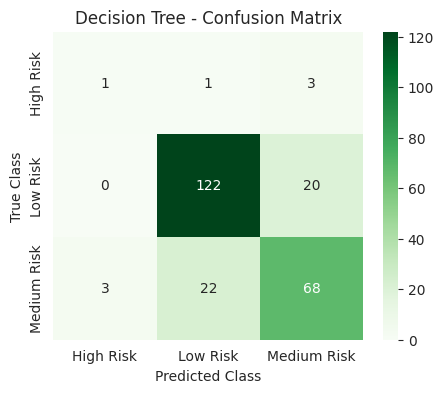

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt

pipe = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42, class_weight='balanced'))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_risk.classes_))
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Greens",
            xticklabels=le_risk.classes_,
            yticklabels=le_risk.classes_)
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

Support Vector Machine Classification Report:
              precision    recall  f1-score   support

   High Risk       0.33      0.40      0.36         5
    Low Risk       0.87      0.93      0.90       142
 Medium Risk       0.85      0.75      0.80        93

    accuracy                           0.85       240
   macro avg       0.69      0.69      0.69       240
weighted avg       0.85      0.85      0.85       240

Accuracy: 0.8500, Precision: 0.8516


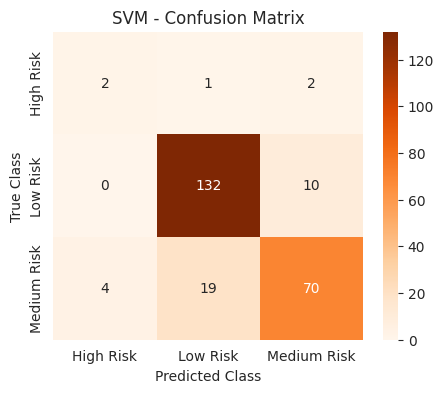

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline


pipe = make_pipeline(preprocessor, SVC(class_weight='balanced'))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)

print("Support Vector Machine Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_risk.classes_))
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Oranges",
            xticklabels=le_risk.classes_,
            yticklabels=le_risk.classes_)
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      0.40      0.57         5
    Low Risk       0.86      0.99      0.92       142
 Medium Risk       0.96      0.78      0.86        93

    accuracy                           0.90       240
   macro avg       0.94      0.72      0.79       240
weighted avg       0.90      0.90      0.89       240

Accuracy: 0.8958, Precision: 0.9044


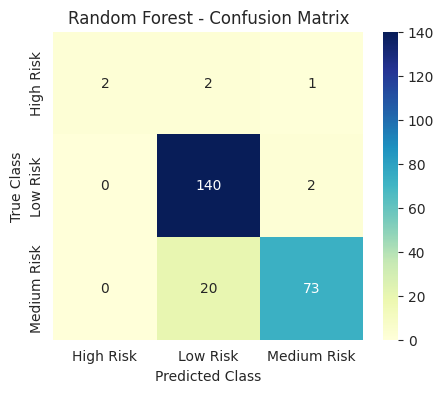

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipe = make_pipeline(preprocessor, RandomForestClassifier(class_weight='balanced', random_state=42))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_risk.classes_))
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}")

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=le_risk.classes_,
            yticklabels=le_risk.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [ ]:
# Step 9: Classification Model Comparison

# Initialize a new list to store classification results
classification_results = []

# Function to evaluate and store classification model results
def evaluate_and_store_classification_model(name, model):
    pipe = make_pipeline(preprocessor, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    report = classification_report(y_test, y_pred, target_names=le_risk.classes_, output_dict=True)

    classification_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'F1-Score (weighted)': report['weighted avg']['f1-score']
    })
    print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}")

# Train and Evaluate Different Classification Models and store results
classification_models = [
    ("Logistic Regression", LogisticRegression(max_iter=500, class_weight='balanced')),
    ("Decision Tree Classifier", DecisionTreeClassifier(random_state=42, class_weight='balanced')),
    ("Support Vector Machine", SVC(probability=True, class_weight='balanced', random_state=42)),
    ("Random Forest Classifier", RandomForestClassifier(class_weight='balanced', random_state=42))
]

for model_name, model_obj in classification_models:
    evaluate_and_store_classification_model(model_name, model_obj)

# Convert results list to DataFrame and display all at once
classification_results_df = pd.DataFrame(classification_results)
print("\nClassifier Performance Comparison Table:")
display(classification_results_df.sort_values(by='Accuracy', ascending=False))

Logistic Regression: Accuracy=0.7500, Precision=0.7957
Decision Tree Classifier: Accuracy=0.7958, Precision=0.7926
Support Vector Machine: Accuracy=0.8500, Precision=0.8516
Random Forest Classifier: Accuracy=0.8958, Precision=0.9044

Classifier Performance Comparison Table:


,Model,Accuracy,Precision,F1-Score (weighted)
3,Random Forest Classifier,0.895833,0.904354,0.891624
2,Support Vector Machine,0.850000,0.851553,0.848868
1,Decision Tree Classifier,0.795833,0.792585,0.794062
0,Logistic Regression,0.750000,0.795694,0.768826


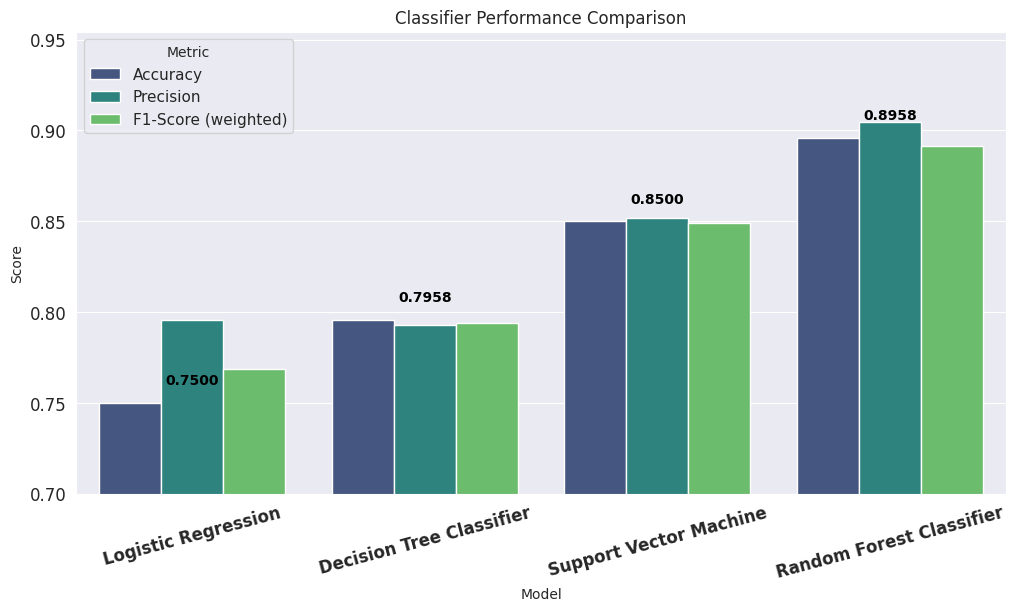

In [ ]:
# Visualize Classification Model Performance

plt.figure(figsize=(12,6))
ax = sns.barplot(data=classification_results_df.melt(id_vars='Model', value_vars=['Accuracy', 'Precision', 'F1-Score (weighted)']),
                 x='Model', y='value', hue='variable', palette='viridis')

plt.title('Classifier Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(classification_results_df[['Accuracy', 'Precision', 'F1-Score (weighted)']].min().min() - 0.05,
         classification_results_df[['Accuracy', 'Precision', 'F1-Score (weighted)']].max().max() + 0.05)
plt.xticks(rotation=15, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.legend(title='Metric', fontsize=11)

# Add text annotations for Accuracy
for i, row in classification_results_df.iterrows():
    ax.text(i, row["Accuracy"] + 0.01, f"{row['Accuracy']:.4f}", ha='center', color='black', fontweight='bold')


plt.show()

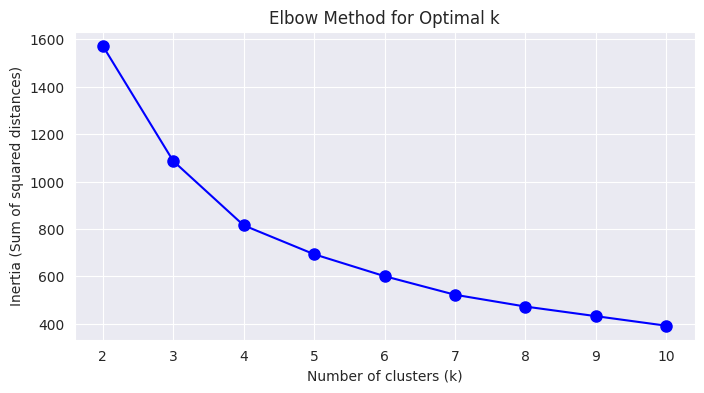

Silhouette Score for k=3: 0.3528


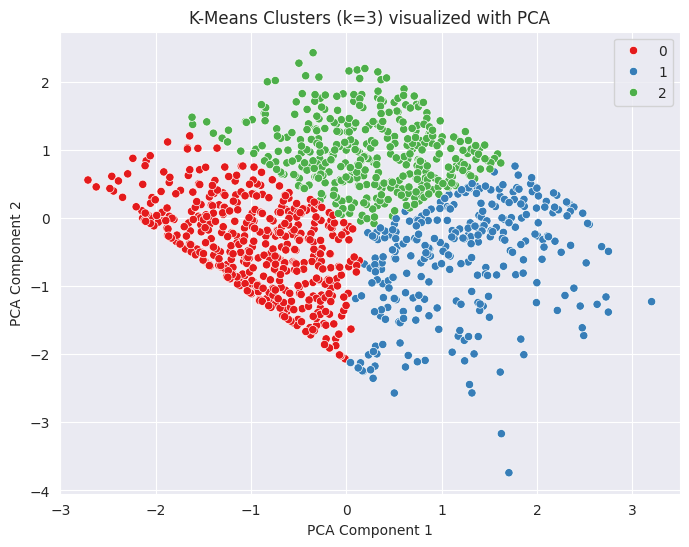

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'data' is your healthcare DataFrame
# and 'lifestyle_features' is a list of feature column names relevant to lifestyle

lifestyle_features = ["age", "bmi", "smoker"]  # replace with your actual columns
X = data[lifestyle_features]

# Preprocessing for clustering
# Categorical features for one-hot encoding
categorical_lifestyle_features = ['smoker']

# Numerical features for scaling
numerical_lifestyle_features = ['age', 'bmi']

# Create a column transformer for preprocessing
# Apply OneHotEncoder to categorical features and StandardScaler to numerical features
preprocessor_clustering = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_lifestyle_features),
    ('cat', OneHotEncoder(drop='first'), categorical_lifestyle_features)
])

# Step 1: Feature scaling and encoding
X_scaled = preprocessor_clustering.fit_transform(X)


# Step 2: Choose the number of clusters (k)
# Use the elbow method to find a good k
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to avoid warning
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, inertia, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Step 3: Fit K-Means with chosen k (e.g., k=3)
k = 3  # set after checking elbow plot
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init
cluster_labels = kmeans.fit_predict(X_scaled)

# Step 4: Add cluster labels to your data
data['LifestyleCluster'] = cluster_labels

# Step 5: Evaluate clustering performance with Silhouette Score
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for k={k}: {sil_score:.4f}")

# Step 6: Visualize clusters if possible (2D using first two features or PCA)
# Since we have more than 2 features after encoding, let's use PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='Set1', legend='full')
plt.title(f'K-Means Clusters (k={k}) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split # Added for robust modeling practice

# Assume 'data' is your healthcare DataFrame
# and 'lifestyle_features' is a list of feature column names relevant to lifestyle

# Features and target
features = ["age", "bmi", "children", "sex", "smoker", "region"]
target_expense = "charges"

# Define disease risk levels and fit risk encoder
bins = [0, 10000, 30000, np.inf]
labels = ['Low Risk', 'Medium Risk', 'High Risk']
data['risk'] = pd.cut(data[target_expense], bins=bins, labels=labels)
le_risk = LabelEncoder()
data['risk_label'] = le_risk.fit_transform(data['risk'])

# Function to create BMI categories
def bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

# Create and fit BMI encoder
data['bmi_category'] = data['bmi'].apply(bmi_category)
label_enc = LabelEncoder() # This is the LabelEncoder for BMI category
data['bmi_category_enc'] = label_enc.fit_transform(data['bmi_category'])

# Update features list to include the BMI category encoding
features = ['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'bmi_category_enc']
X = data[features]
y_exp = data[target_expense]
y_risk = data['risk_label']

# Preprocessing
numerical_cols = ['age', 'bmi', 'children', 'bmi_category_enc']
categorical_cols = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
])

# --- 4. Model Training ---

# Regression model for Cost
reg_pipeline = make_pipeline(preprocessor, ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=42))
reg_pipeline.fit(X, y_exp)

# Classification model for Risk
clf_pipeline = make_pipeline(preprocessor, SVC(probability=True, random_state=42))
clf_pipeline.fit(X, y_risk)

# Clustering model for Lifestyle
kmeans_pipeline = make_pipeline(preprocessor, KMeans(n_clusters=3, random_state=42, n_init=10))
data['LifestyleCluster'] = kmeans_pipeline.fit_predict(X)

# PCA for visualization
X_processed = preprocessor.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)


# --- 5. User Interaction Functions ---

def get_user_input():
    """Collects and validates user input."""
    print("\n\n🩺 Enter patient details:")

    name = input("Patient Name: ").strip()

    # Input required for the 7 features
    age = int(input("Age: "))
    bmi = float(input("BMI: "))
    children = int(input("Number of children: "))

    smoker = ""
    while smoker not in ['yes', 'no']:
        smoker = input("Smoker (yes/no): ").strip().lower()

    sex = ""
    while sex not in ['male', 'female']:
        sex = input("Sex (male/female): ").strip().lower()

    region = ""
    valid_regions = ['southeast', 'northwest', 'southwest', 'northeast']
    while region not in valid_regions:
        region = input(f"Region ({', '.join(valid_regions)}): ").strip().lower()

    # Encode BMI category
    bmi_cat = bmi_category(bmi)
    bmi_cat_enc = label_enc.transform([bmi_cat])[0]

    # Return the name and the 7 model features in the EXACT order of 'features'
    model_features = [age, bmi, children, sex, smoker, region, bmi_cat_enc]
    return name, model_features

def predict_and_display():
    """Predicts metrics and displays results, and visualizes the cluster."""

    name, user_features = get_user_input()
    if user_features is None:
        return

    # Create DataFrame for prediction - Columns MUST match the training features list
    user_df = pd.DataFrame([user_features], columns=features)

    # --- Predictions ---

    # 1. Medical Cost
    medical_cost = reg_pipeline.predict(user_df)[0]

    # 2. Disease Risk
    risk_pred = clf_pipeline.predict(user_df)[0]
    risk_proba = clf_pipeline.predict_proba(user_df).max(axis=1)[0]
    risk_label = le_risk.inverse_transform([risk_pred])[0]

    # 3. Lifestyle Cluster
    cluster_pred = kmeans_pipeline.predict(user_df)[0]

    # Calculate Cluster Profile (Average values for the predicted cluster)
    cluster_profile = data[data['LifestyleCluster'] == cluster_pred][numerical_cols].mean().round(2)

    # --- Lifestyle Improvement Suggestion Logic ---
    improvement_suggestion = ""
    user_bmi_cat = bmi_category(user_df['bmi'][0])

    if user_df['smoker'][0] == 'yes':
        improvement_suggestion += "🔥 **Quit Smoking:** This is the most crucial step to reduce risk and cost. "

    if 'Overweight' in user_bmi_cat or 'Obese' in user_bmi_cat:
        improvement_suggestion += "🥗 **Weight Management:** Focus on diet and exercise (BMI > 25 is Overweight/Obese). "

    if improvement_suggestion == "":
        improvement_suggestion = "✅ **Excellent:** Maintain your current healthy lifestyle."

    if risk_label == 'High Risk':
        improvement_suggestion += " ⚠️ **High Priority:** Consult your physician for a full health assessment."

    # --- Display Results ---
    print("\n=============================================")
    print(f"👤 Patient: {name}")
    print("Health Prediction Report")

    print(f"Predicted Total Medical Expense: ${medical_cost:,.2f}")
    print(f"Disease Risk Level: {risk_label} (Confidence: {risk_proba*100:.1f}%)")
    print(f"Patient Lifestyle Cluster: Cluster {cluster_pred}")

    print("\n--- Cluster Profile (Avg. Patient in this Group) ---")
    print(cluster_profile.to_string())

    print("\n--- Key Lifestyle Improvements ---")
    print(f"Suggestion: {improvement_suggestion}")
    print("=============================================")

    # --- Visualization ---
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data['LifestyleCluster'], palette='Set1', alpha=0.6, legend='full')

    # Transform user input for PCA visualization
    user_processed = preprocessor.transform(user_df)
    user_pca = pca.transform(user_processed)

    plt.scatter(user_pca[:,0], user_pca[:,1], color='black', s=200, marker='X', label=name, zorder=10)
    plt.title(f"Patient Lifestyle Cluster Location (PCA Projection)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Cluster')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Run the interactive system ---
predict_and_display()



🩺 Enter patient details:
